In [110]:
import pandas as pd

def train_test_split_time(df: pd.DataFrame, aus_port: str, for_port: str, test_length: int = 9):
    """
    Splits time-series data into train and test sets for a given city pair.

    Parameters:
        df: DataFrame with the dataset!
        aus_port: It refers to the Australian Port provided in the route.
        for_port: It refers to the Foreign Port provided in the route.
        horizon (int): Number of months to keep for testing. Kept as 9 (in between 6-12 months).
    """
    route_df = (df[((df["AustralianPort"] == aus_port) & (df["ForeignPort"] == for_port))]
                .sort_values("MonthYear").reset_index(drop=True))

    train = route_df.iloc[:-test_length]
    test = route_df.iloc[-test_length:]

    return train, test

In [111]:
df = pd.read_csv("../../data/aeroconnect_cleaned.csv")
train, test = train_test_split_time(df=df, aus_port="Sydney", for_port="Auckland")

print("Train range:", train["MonthYear"].min(), "→", train["MonthYear"].max())
print("Test range:", test["MonthYear"].min(), "→", test["MonthYear"].max())

Train range: 1985-01-01 → 1988-09-01
Test range: 1988-10-01 → 1989-06-01


In [112]:
def create_lag_features(series, n_lags=12):
    """
    This method prepares the input for time-series forecasting by creating "lag features". Each lag column corresponds to value of "PassengersTotal" from previous time-steps, which can be used as predictors for the current value.
    :param series: DataFrame.
    :param n_lags: Number of lagged time-steps to generate features for.
    :return: DataFrame with lag features!!
    """
    df = pd.DataFrame(series)
    for lag in range(1, n_lags+1):
        df[f'lag_{lag}'] = df['PassengersTotal'].shift(lag)
    df = df.dropna()
    return df

In [113]:
df_lagged = create_lag_features(train[['PassengersTotal']], n_lags=12)

X = df_lagged.drop(columns=['PassengersTotal'])
y = df_lagged['PassengersTotal']

test_size = min(9, len(df_lagged)//2)
train = df_lagged.iloc[:-test_size]
test = df_lagged.iloc[-test_size:]

In [114]:
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd

def run_knn_forecast(train, test, features, target="PassengersTotal", k=5):
    """
    Runs k-NN regression for forecasting passenger counts.
    Includes absolute error accuracy calculation.
    """
    X_train, y_train = train[features], train[target]
    X_test, y_test = test[features], test[target]

    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)

    predictions = knn.predict(X_test)

    results = pd.DataFrame({
        "Actual": y_test.values,
        "Predicted": predictions
    })

    results["AbsError"] = abs(results["Predicted"] - results["Actual"])
    results["Accuracy"] = 1 - (results["AbsError"] / results["Actual"])

    total_abs_error = results["AbsError"].sum()
    mean_accuracy = results["Accuracy"].mean()

    return results, total_abs_error, mean_accuracy


In [115]:
features = [col for col in train.columns if "lag" in col]
results, error, accuracy = run_knn_forecast(train, test, features, target="PassengersTotal", k=5)

print("Total Absolute Error:", error)
print("Mean Accuracy:", round(accuracy * 100, 2), "%")


Total Absolute Error: 45230.799999999996
Mean Accuracy: 92.22 %


In [116]:
import matplotlib.pyplot as plt

def plot_port_pair_forecast_knn(df, aus_port, foreign_port, n_lags=12, min_history=24, n_neighbors=5):
    group = df[(df["AustralianPort"] == aus_port) & (df["ForeignPort"] == foreign_port)]
    group = group.sort_values("MonthYear")

    if len(group) < min_history:
        print(f"Not enough history for {aus_port}-{foreign_port}")
        return

    df_lags = create_lag_features(group['PassengersTotal'], n_lags=n_lags)
    if len(df_lags) < 2:
        print(f"Not enough lagged data for {aus_port}-{foreign_port}")
        return

    test_size = min(9, len(df_lags)//2)
    train = df_lags.iloc[:-test_size]
    test = df_lags.iloc[-test_size:]

    X_train = train.drop(columns='PassengersTotal').values
    y_train = train['PassengersTotal'].values
    X_test = test.drop(columns='PassengersTotal').values
    y_test = test['PassengersTotal'].values

    model = KNeighborsRegressor(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)
    forecast = model.predict(X_test)
    results = pd.DataFrame({
        "Actual": y_test,
        "Predicted": forecast
    })

    results["AbsError"] = abs(results["Predicted"] - results["Actual"])
    results["Accuracy"] = 1 - (results["AbsError"] / results["Actual"])

    total_abs_error = results["AbsError"].sum()
    mean_accuracy = results["Accuracy"].mean()

    plt.figure(figsize=(10, 5))
    plt.plot(group["MonthYear"].iloc[n_lags: -test_size], y_train, label="Train (Actual)", color="blue")
    plt.plot(group["MonthYear"].iloc[-test_size:], y_test, label="Test (Actual)", color="black", linestyle="dashed")
    plt.plot(group["MonthYear"].iloc[-test_size:], forecast, label=f"Forecast (k-NN, k={n_neighbors})", color="red")

    plt.title(f"K-NN: Passenger Forecast (k-NN): {aus_port} → {foreign_port}")
    plt.xlabel("Date")
    plt.xticks(rotation=90)
    plt.ylabel("Passengers")
    plt.legend()
    plt.grid(True)
    plt.show()

    return results, total_abs_error, mean_accuracy


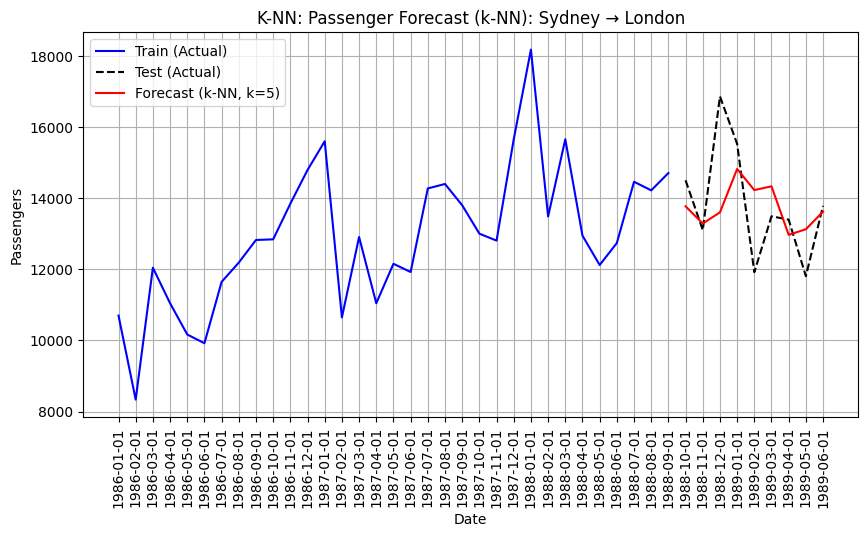

Total Absolute Error: 9941.6
Mean Accuracy: 92.06 %


In [117]:
features = [col for col in train.columns if "lag" in col]
results, error, accuracy = plot_port_pair_forecast_knn(df, aus_port="Sydney", foreign_port="London")

print("Total Absolute Error:", error)
print("Mean Accuracy:", round(accuracy * 100, 2), "%")